In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')


# In[20]:


import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import logging
import sys


# In[ ]:





# In[3]:


import optuna


# In[ ]:



optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))


# In[4]:


### study params
 # Unique identifier of the study.
study_name    = "AE_step_one_test"  # Unique identifier of the study.
storage_name  = "sqlite:///{}.db".format(study_name)
SEED          = 512
EPOCHS        = 10


# In[5]:


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Reshape, LeakyReLU, BatchNormalization, Dense, Flatten, Input,Dropout


# In[6]:


### settings
# user defined span (following Yip et al and Portillo et al)
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'

root_prepped    = os.path.join(root_data,'sdss/prepped')

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000

label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'
label_2         = label+'_minz01_maxz036_minSN50_good'+'_10_fully_connected_mean_div'

seed            = 8720

network_type    = 'fully_connected'

cond_on         = 'type'


# In[7]:


wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)


# In[8]:


train_data = np.load(os.path.join(root_model_data,'train_%s.npy.npz'%label_2))
valid_data = np.load(os.path.join(root_model_data,'valid_%s.npy.npz'%label_2))
test_data = np.load(os.path.join(root_model_data,'test_%s.npy.npz'%label_2))


# In[9]:


keys = ('spec', 'mask', 'noise', 'z', 'RA', 'DE', 'class', 'subclass', 'mean', 'std')


# In[10]:


train = {}
for item, key in zip(train_data.files, keys):
    train[key] = train_data[item]
    
    
valid = {}
for item, key in zip(valid_data.files, keys):
    valid[key] =  valid_data[item]
    
test = {}
for item, key in zip(test_data.files, keys):
    test[key] = test_data[item]


# In[11]:


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train['subclass'])
train['subclass'] = le.transform(train['subclass'])
valid['subclass'] = le.transform(valid['subclass'])
test['subclass']  = le.transform(test['subclass'])
print(le.classes_, le.transform(le.classes_))


# In[12]:


def dense_cond_block(x,z,num, non_lin=True):
    x = tf.concat([x,z], axis=1)
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)

def dense_block(x,num, non_lin=True):
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return x


# In[13]:


dim = fixed_num_bins


# In[14]:


def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(data, training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}


# In[ ]:





# In[15]:


def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1])])
    return valid_loss


# In[16]:


def objective(trial):
    input        = Input(shape=(dim,1))
    input_mask   = Input(shape=(dim,1))
    input_noise  = Input(shape=(dim,1))
    input_type   = Input(shape=(1,1))
    input_params = Input(shape=(1,1))

    if cond_on=='type':
        z = input_type
    if cond_on=='redshift':
        z = input_params

    x = input
    n_layers   = trial.suggest_int('n_layers', 2, 7)
    latent_dim = trial.suggest_int('latent_dim', 2, 12)

    out_features = []
    for ii in range(n_layers-1):
        if ii >0:
            out_features.append(trial.suggest_int('n_units_l{}'.format(ii), latent_dim, min(dim,2*out_features[-1])))
            p = 0#trial.suggest_float("dropout_l{}".format(ii), 0.1, 0.3)
        else:
            out_features.append(trial.suggest_int('n_units_l{}'.format(ii), latent_dim,dim))
            p = 0
        x = Dropout(p)(x)
        x = dense_block(x,out_features[ii])
    x = dense_block(x,latent_dim,non_lin=False)
    x = Reshape((latent_dim,1))(x)
    for ii in range(n_layers-1):
        x = dense_cond_block(x,z,out_features[-1-ii])
        if ii ==0:
            p=0
        else:
            p = 0#trial.suggest_float("dropout_l{}".format(ii), 0.1, 0.3)
    x = Dropout(p)(x)
    x = dense_cond_block(x,z,dim, non_lin=False)

    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    batchsize = trial.suggest_int("batchsize", 32 , 256)
    lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_type, input_params], outputs=x)
    lstm_ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), my_loss=lossFunction, metrics=[],run_eagerly=False)

    #lstm_ae.summary()

    lstm_ae.fit(x=(train['spec'],train['mask'],train['noise'], np.expand_dims(train['subclass'],-1), np.expand_dims(train['z'],-1)), batch_size=batchsize, epochs=EPOCHS)

    res_valid   = lstm_ae.predict((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']))
    recon_error = custom_metric((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']),res_valid)
    
    return recon_error







[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE'] [0 1 2 3 4 5 6 7]


[I 2021-09-28 09:21:48,730] A new study created in RDB with name: AE_step_one_test


A new study created in RDB with name: AE_step_one_test
Epoch 1/10
1379/1379 [==============================] - 10s 7ms/step - training_loss: 11.2903
Epoch 2/10
1379/1379 [==============================] - 10s 7ms/step - training_loss: 2.3609
Epoch 3/10
1379/1379 [==============================] - 10s 7ms/step - training_loss: 2.0601
Epoch 4/10
1379/1379 [==============================] - 10s 7ms/step - training_loss: 1.9803
Epoch 5/10
1379/1379 [==============================] - 10s 7ms/step - training_loss: 1.9217
Epoch 6/10
1379/1379 [==============================] - 10s 7ms/step - training_loss: 1.8671
Epoch 7/10
1379/1379 [==============================] - 10s 7ms/step - training_loss: 1.8377
Epoch 8/10
1379/1379 [==============================] - 10s 7ms/step - training_loss: 1.8131
Epoch 9/10
1379/1379 [==============================] - 10s 7ms/step - training_loss: 1.7836
Epoch 10/10
1379/1379 [==============================] - 10s 7ms/step - training_loss: 1.7671


[I 2021-09-28 09:23:31,944] Trial 0 finished with value: 1.7933597734218196 and parameters: {'n_layers': 2, 'latent_dim': 4, 'n_units_l0': 390, 'lr': 0.00028878190999123644, 'batchsize': 51}. Best is trial 0 with value: 1.7933597734218196.


Trial 0 finished with value: 1.7933597734218196 and parameters: {'n_layers': 2, 'latent_dim': 4, 'n_units_l0': 390, 'lr': 0.00028878190999123644, 'batchsize': 51}. Best is trial 0 with value: 1.7933597734218196.
Epoch 1/10
412/412 [==============================] - 6s 15ms/step - training_loss: 634331.5606
Epoch 2/10
412/412 [==============================] - 6s 15ms/step - training_loss: 31.4591
Epoch 3/10
412/412 [==============================] - 6s 16ms/step - training_loss: 24.3995
Epoch 4/10
412/412 [==============================] - 6s 16ms/step - training_loss: 22.0093
Epoch 5/10
412/412 [==============================] - 6s 15ms/step - training_loss: 139.5976
Epoch 6/10
412/412 [==============================] - 6s 15ms/step - training_loss: 18.3490
Epoch 7/10
412/412 [==============================] - 6s 16ms/step - training_loss: 16.8770
Epoch 8/10
412/412 [==============================] - 7s 16ms/step - training_loss: 14.6731
Epoch 9/10
412/412 [===========================

[I 2021-09-28 09:24:40,370] Trial 1 finished with value: 8.505262688569731 and parameters: {'n_layers': 3, 'latent_dim': 7, 'n_units_l0': 563, 'n_units_l1': 266, 'lr': 0.013451934818761384, 'batchsize': 171}. Best is trial 0 with value: 1.7933597734218196.


Trial 1 finished with value: 8.505262688569731 and parameters: {'n_layers': 3, 'latent_dim': 7, 'n_units_l0': 563, 'n_units_l1': 266, 'lr': 0.013451934818761384, 'batchsize': 171}. Best is trial 0 with value: 1.7933597734218196.
Epoch 1/10
1234/1234 [==============================] - 10s 8ms/step - training_loss: 21.7150
Epoch 2/10
1234/1234 [==============================] - 10s 8ms/step - training_loss: 3.3496
Epoch 3/10
1234/1234 [==============================] - 10s 8ms/step - training_loss: 2.8493
Epoch 4/10
1234/1234 [==============================] - 10s 8ms/step - training_loss: 2.5064
Epoch 5/10
1234/1234 [==============================] - 11s 9ms/step - training_loss: 2.2953
Epoch 6/10
1234/1234 [==============================] - 10s 8ms/step - training_loss: 2.0828
Epoch 7/10
1234/1234 [==============================] - 10s 8ms/step - training_loss: 2.0267
Epoch 8/10
1234/1234 [==============================] - 11s 9ms/step - training_loss: 1.9625
Epoch 9/10
1234/1234 [====

[I 2021-09-28 09:26:29,202] Trial 2 finished with value: 1.8662201193518162 and parameters: {'n_layers': 7, 'latent_dim': 10, 'n_units_l0': 37, 'n_units_l1': 53, 'n_units_l2': 52, 'n_units_l3': 101, 'n_units_l4': 74, 'n_units_l5': 147, 'lr': 0.00048104922017066625, 'batchsize': 57}. Best is trial 0 with value: 1.7933597734218196.


Trial 2 finished with value: 1.8662201193518162 and parameters: {'n_layers': 7, 'latent_dim': 10, 'n_units_l0': 37, 'n_units_l1': 53, 'n_units_l2': 52, 'n_units_l3': 101, 'n_units_l4': 74, 'n_units_l5': 147, 'lr': 0.00048104922017066625, 'batchsize': 57}. Best is trial 0 with value: 1.7933597734218196.
Epoch 1/10
697/697 [==============================] - 8s 12ms/step - training_loss: 42.1943
Epoch 2/10
697/697 [==============================] - 8s 12ms/step - training_loss: 3.4331
Epoch 3/10
697/697 [==============================] - 8s 12ms/step - training_loss: 2.7681
Epoch 4/10
697/697 [==============================] - 8s 12ms/step - training_loss: 2.5047
Epoch 5/10
697/697 [==============================] - 8s 12ms/step - training_loss: 2.5952
Epoch 6/10
697/697 [==============================] - 8s 12ms/step - training_loss: 2.1843
Epoch 7/10
697/697 [==============================] - 8s 12ms/step - training_loss: 2.0786
Epoch 8/10
697/697 [==============================] - 8s 1

[I 2021-09-28 09:27:55,534] Trial 3 finished with value: 43.42583978851163 and parameters: {'n_layers': 2, 'latent_dim': 7, 'n_units_l0': 895, 'lr': 0.0032140935901591164, 'batchsize': 101}. Best is trial 0 with value: 1.7933597734218196.


Trial 3 finished with value: 43.42583978851163 and parameters: {'n_layers': 2, 'latent_dim': 7, 'n_units_l0': 895, 'lr': 0.0032140935901591164, 'batchsize': 101}. Best is trial 0 with value: 1.7933597734218196.
Epoch 1/10
1675/1675 [==============================] - 28s 17ms/step - training_loss: 45.8074
Epoch 2/10
1675/1675 [==============================] - 28s 17ms/step - training_loss: 3.4516
Epoch 3/10
1675/1675 [==============================] - 28s 17ms/step - training_loss: 3.2115
Epoch 4/10
1675/1675 [==============================] - 28s 17ms/step - training_loss: 2.8909
Epoch 5/10
1675/1675 [==============================] - 29s 17ms/step - training_loss: 2.5205
Epoch 6/10
1675/1675 [==============================] - 28s 17ms/step - training_loss: 2.3851
Epoch 7/10
1675/1675 [==============================] - 28s 17ms/step - training_loss: 2.2786
Epoch 8/10
1675/1675 [==============================] - 29s 17ms/step - training_loss: 2.1316
Epoch 9/10
1675/1675 [==============

[I 2021-09-28 09:32:45,437] Trial 4 finished with value: 1.9885926103557006 and parameters: {'n_layers': 6, 'latent_dim': 8, 'n_units_l0': 499, 'n_units_l1': 539, 'n_units_l2': 742, 'n_units_l3': 111, 'n_units_l4': 202, 'lr': 1.5623112547068073e-05, 'batchsize': 42}. Best is trial 0 with value: 1.7933597734218196.


Trial 4 finished with value: 1.9885926103557006 and parameters: {'n_layers': 6, 'latent_dim': 8, 'n_units_l0': 499, 'n_units_l1': 539, 'n_units_l2': 742, 'n_units_l3': 111, 'n_units_l4': 202, 'lr': 1.5623112547068073e-05, 'batchsize': 42}. Best is trial 0 with value: 1.7933597734218196.


In [15]:

study = optuna.create_study(direction='minimize',study_name=study_name, storage=storage_name,load_if_exists=True,  sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=10, timeout=600)

[I 2021-09-28 09:46:10,586] Using an existing study with name 'AE_step_one_test' instead of creating a new one.


Using an existing study with name 'AE_step_one_test' instead of creating a new one.
Epoch 1/10
1379/1379 [==============================] - 11s 8ms/step - training_loss: 11.3064
Epoch 2/10
1379/1379 [==============================] - 11s 8ms/step - training_loss: 2.3296
Epoch 3/10
1379/1379 [==============================] - 11s 8ms/step - training_loss: 2.0503
Epoch 4/10
1379/1379 [==============================] - 11s 8ms/step - training_loss: 1.9619
Epoch 5/10
1379/1379 [==============================] - 11s 8ms/step - training_loss: 1.9146
Epoch 6/10
1379/1379 [==============================] - 11s 8ms/step - training_loss: 1.8599
Epoch 7/10
1379/1379 [==============================] - 11s 8ms/step - training_loss: 1.8339
Epoch 8/10
1379/1379 [==============================] - 11s 8ms/step - training_loss: 1.7980
Epoch 9/10
1379/1379 [==============================] - 11s 8ms/step - training_loss: 1.7968
Epoch 10/10
1379/1379 [==============================] - 11s 8ms/step - traini

[I 2021-09-28 09:48:03,965] Trial 5 finished with value: 1.6946405231611212 and parameters: {'n_layers': 2, 'latent_dim': 4, 'n_units_l0': 390, 'lr': 0.00028878190999123644, 'batchsize': 51}. Best is trial 5 with value: 1.6946405231611212.


Trial 5 finished with value: 1.6946405231611212 and parameters: {'n_layers': 2, 'latent_dim': 4, 'n_units_l0': 390, 'lr': 0.00028878190999123644, 'batchsize': 51}. Best is trial 5 with value: 1.6946405231611212.
Epoch 1/10
412/412 [==============================] - 7s 18ms/step - training_loss: 212949.3144
Epoch 2/10
412/412 [==============================] - 7s 18ms/step - training_loss: 34.1396
Epoch 3/10
412/412 [==============================] - 7s 17ms/step - training_loss: 37.6333
Epoch 4/10
412/412 [==============================] - 7s 18ms/step - training_loss: 30.1543
Epoch 5/10
412/412 [==============================] - 8s 19ms/step - training_loss: 15.1833
Epoch 6/10
412/412 [==============================] - 8s 19ms/step - training_loss: 13.3390
Epoch 7/10
412/412 [==============================] - 7s 18ms/step - training_loss: 8.7202
Epoch 8/10
412/412 [==============================] - 7s 18ms/step - training_loss: 640528338283287.1250
Epoch 9/10
412/412 [================

[I 2021-09-28 09:49:23,201] Trial 6 finished with value: 9348898071.036478 and parameters: {'n_layers': 3, 'latent_dim': 7, 'n_units_l0': 563, 'n_units_l1': 266, 'lr': 0.013451934818761384, 'batchsize': 171}. Best is trial 5 with value: 1.6946405231611212.


Trial 6 finished with value: 9348898071.036478 and parameters: {'n_layers': 3, 'latent_dim': 7, 'n_units_l0': 563, 'n_units_l1': 266, 'lr': 0.013451934818761384, 'batchsize': 171}. Best is trial 5 with value: 1.6946405231611212.
Epoch 1/10
1234/1234 [==============================] - 11s 9ms/step - training_loss: 19.9894
Epoch 2/10
1234/1234 [==============================] - 11s 9ms/step - training_loss: 3.4227
Epoch 3/10
1234/1234 [==============================] - 11s 9ms/step - training_loss: 3.0397
Epoch 4/10
1234/1234 [==============================] - 13s 10ms/step - training_loss: 2.5556
Epoch 5/10
1234/1234 [==============================] - 12s 10ms/step - training_loss: 2.4207
Epoch 6/10
1234/1234 [==============================] - 13s 10ms/step - training_loss: 2.2468
Epoch 7/10
1234/1234 [==============================] - 13s 10ms/step - training_loss: 2.0997
Epoch 8/10
1234/1234 [==============================] - 13s 10ms/step - training_loss: 2.0124
Epoch 9/10
1234/1234 

[I 2021-09-28 09:51:31,346] Trial 7 finished with value: 1.9601684323473774 and parameters: {'n_layers': 7, 'latent_dim': 10, 'n_units_l0': 37, 'n_units_l1': 53, 'n_units_l2': 52, 'n_units_l3': 101, 'n_units_l4': 74, 'n_units_l5': 147, 'lr': 0.00048104922017066625, 'batchsize': 57}. Best is trial 5 with value: 1.6946405231611212.


Trial 7 finished with value: 1.9601684323473774 and parameters: {'n_layers': 7, 'latent_dim': 10, 'n_units_l0': 37, 'n_units_l1': 53, 'n_units_l2': 52, 'n_units_l3': 101, 'n_units_l4': 74, 'n_units_l5': 147, 'lr': 0.00048104922017066625, 'batchsize': 57}. Best is trial 5 with value: 1.6946405231611212.
Epoch 1/10
697/697 [==============================] - 11s 16ms/step - training_loss: 32.6349
Epoch 2/10
697/697 [==============================] - 12s 17ms/step - training_loss: 2.9435
Epoch 3/10
697/697 [==============================] - 11s 16ms/step - training_loss: 2.5918
Epoch 4/10
697/697 [==============================] - 11s 16ms/step - training_loss: 2.4429
Epoch 5/10
697/697 [==============================] - 11s 16ms/step - training_loss: 2.1526
Epoch 6/10
697/697 [==============================] - 11s 16ms/step - training_loss: 2.3032
Epoch 7/10
697/697 [==============================] - 11s 16ms/step - training_loss: 23898.7696
Epoch 8/10
697/697 [===========================

[I 2021-09-28 09:53:29,977] Trial 8 finished with value: 6.41190330489732 and parameters: {'n_layers': 2, 'latent_dim': 7, 'n_units_l0': 895, 'lr': 0.0032140935901591164, 'batchsize': 101}. Best is trial 5 with value: 1.6946405231611212.


Trial 8 finished with value: 6.41190330489732 and parameters: {'n_layers': 2, 'latent_dim': 7, 'n_units_l0': 895, 'lr': 0.0032140935901591164, 'batchsize': 101}. Best is trial 5 with value: 1.6946405231611212.
Epoch 1/10
1675/1675 [==============================] - 42s 25ms/step - training_loss: 44.7664 0s - training
Epoch 2/10
1675/1675 [==============================] - 43s 26ms/step - training_loss: 3.4349
Epoch 3/10
1675/1675 [==============================] - 43s 26ms/step - training_loss: 3.1787
Epoch 4/10
1675/1675 [==============================] - 41s 24ms/step - training_loss: 2.7927
Epoch 5/10
1675/1675 [==============================] - 41s 24ms/step - training_loss: 2.4983
Epoch 6/10
1675/1675 [==============================] - 38s 23ms/step - training_loss: 2.3302
Epoch 7/10
1675/1675 [==============================] - 38s 23ms/step - training_loss: 2.1724
Epoch 8/10
1675/1675 [==============================] - 40s 24ms/step - training_loss: 2.0513
Epoch 9/10
1675/1675 [=

[I 2021-09-28 10:00:27,133] Trial 9 finished with value: 1.9343001335946353 and parameters: {'n_layers': 6, 'latent_dim': 8, 'n_units_l0': 499, 'n_units_l1': 539, 'n_units_l2': 742, 'n_units_l3': 111, 'n_units_l4': 202, 'lr': 1.5623112547068073e-05, 'batchsize': 42}. Best is trial 5 with value: 1.6946405231611212.


Trial 9 finished with value: 1.9343001335946353 and parameters: {'n_layers': 6, 'latent_dim': 8, 'n_units_l0': 499, 'n_units_l1': 539, 'n_units_l2': 742, 'n_units_l3': 111, 'n_units_l4': 202, 'lr': 1.5623112547068073e-05, 'batchsize': 42}. Best is trial 5 with value: 1.6946405231611212.


In [16]:
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))

In [17]:
df

,number,value,params_batchsize,params_latent_dim,params_lr,params_n_layers,params_n_units_l0,params_n_units_l1,params_n_units_l2,params_n_units_l3,params_n_units_l4,params_n_units_l5,state
0,0,1.793360e+00,51,4,0.000289,2,390,NaN,NaN,NaN,NaN,NaN,COMPLETE
1,1,8.505263e+00,171,7,0.013452,3,563,266.0,NaN,NaN,NaN,NaN,COMPLETE
2,2,1.866220e+00,57,10,0.000481,7,37,53.0,52.0,101.0,74.0,147.0,COMPLETE
3,3,4.342584e+01,101,7,0.003214,2,895,NaN,NaN,NaN,NaN,NaN,COMPLETE
4,4,1.988593e+00,42,8,0.000016,6,499,539.0,742.0,111.0,202.0,NaN,COMPLETE
5,5,1.694641e+00,51,4,0.000289,2,390,NaN,NaN,NaN,NaN,NaN,COMPLETE
6,6,9.348898e+09,171,7,0.013452,3,563,266.0,NaN,NaN,NaN,NaN,COMPLETE
7,7,1.960168e+00,57,10,0.000481,7,37,53.0,52.0,101.0,74.0,147.0,COMPLETE
8,8,6.411903e+00,101,7,0.003214,2,895,NaN,NaN,NaN,NaN,NaN,COMPLETE
9,9,1.934300e+00,42,8,0.000016,6,499,539.0,742.0,111.0,202.0,NaN,COMPLETE


(0, 3)

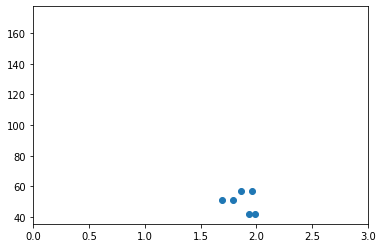

In [23]:
plt.scatter(df['value'], df['params_batchsize'])
plt.xlim(0,3)

In [18]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

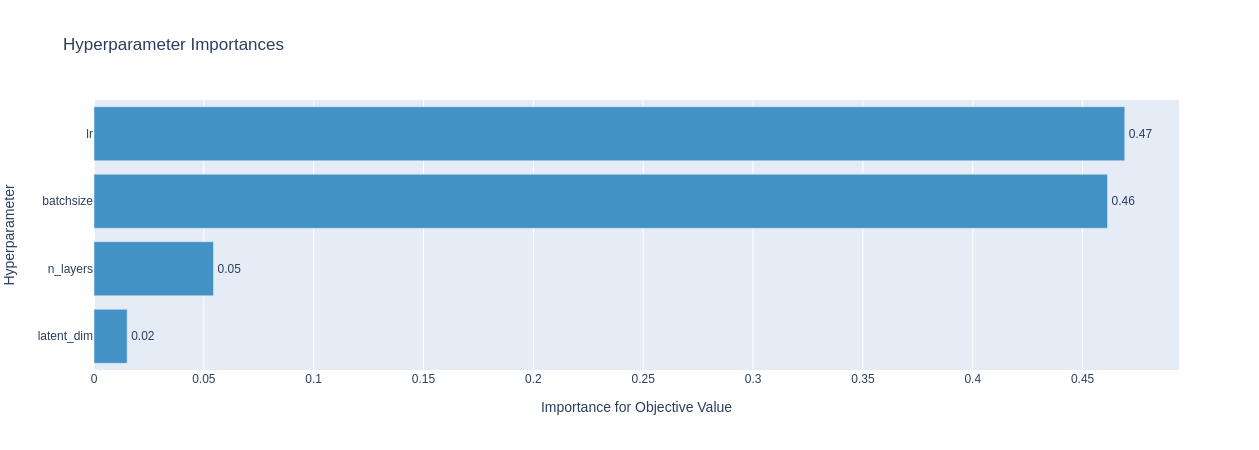

In [19]:
plot_param_importances(study)

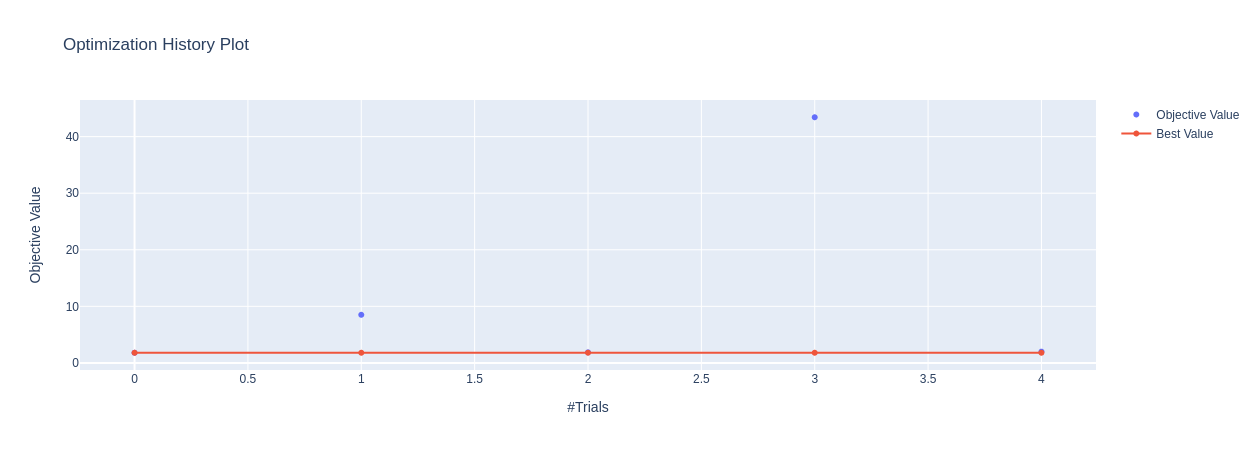

In [9]:
plot_optimization_history(study)

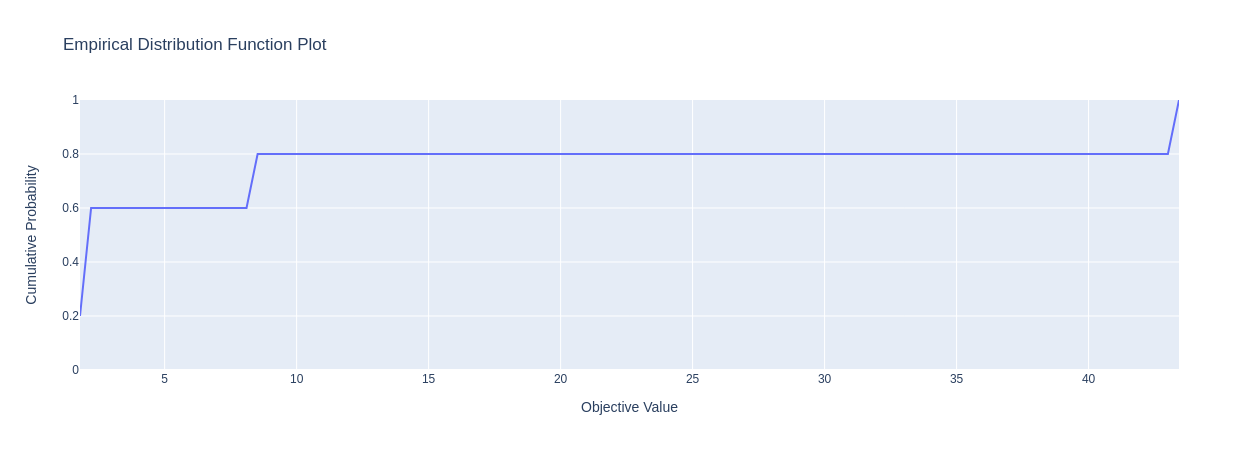

In [10]:
plot_edf(study)

In [11]:
del study

In [12]:
study = optuna.create_study(direction='minimize',study_name=study_name, storage=storage_name,load_if_exists=True,  sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

[I 2021-09-28 09:42:42,328] Using an existing study with name 'AE_step_one_test' instead of creating a new one.


Using an existing study with name 'AE_step_one_test' instead of creating a new one.


In [13]:
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))

In [14]:
df

,number,value,params_batchsize,params_latent_dim,params_lr,params_n_layers,params_n_units_l0,params_n_units_l1,params_n_units_l2,params_n_units_l3,params_n_units_l4,params_n_units_l5,state
0,0,1.793360,51,4,0.000289,2,390,NaN,NaN,NaN,NaN,NaN,COMPLETE
1,1,8.505263,171,7,0.013452,3,563,266.0,NaN,NaN,NaN,NaN,COMPLETE
2,2,1.866220,57,10,0.000481,7,37,53.0,52.0,101.0,74.0,147.0,COMPLETE
3,3,43.425840,101,7,0.003214,2,895,NaN,NaN,NaN,NaN,NaN,COMPLETE
4,4,1.988593,42,8,0.000016,6,499,539.0,742.0,111.0,202.0,NaN,COMPLETE
